### 0 - Preparação do ambiente

#### 0.1 - Instalação de bibliotecas utilizadas ao longo do código

In [0]:
%pip install pandas --quiet
%pip install matplotlib --quiet
%pip install seaborn --quiet
%pip install tabulate --quiet
%pip install numpy --quiet

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


#### 0.2 - Importação dos pacotes

In [0]:
#importação de pacotes

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tabulate import tabulate
from pyspark.sql import SparkSession
import numpy as np

#### 0.3 - Criação dos schemas de dados

Para a criação dos schemas de dados, adotou-se a arquitetura Medallion, permitindo a segregação de tabelas em diferentes níveis de transformação. [Utilizando como referência o próprio site do Databricks](https://www.databricks.com/glossary/medallion-architecture), consideraram-se os seguintes descritivos:

- **Tabelas nível Bronze:** Contêm os dados brutos, conforme extração da fonte de dados;
- **Tabelas nível Silver:** Contêm os dados tratados e refinados, assegurando a padronização a partir das tabelas do nível Bronze;
- **Tabelas nível Gold:** Representam as tabelas analíticas finais, obtidas após processos de integração e enriquecimento, prontas para consumo e análise.

In [0]:
%sql

DROP DATABASE IF EXISTS bronze CASCADE;
DROP DATABASE IF EXISTS silver CASCADE;
DROP DATABASE IF EXISTS gold CASCADE;

CREATE DATABASE bronze;
CREATE DATABASE silver;
CREATE DATABASE gold;

#### 0.4 - Funções utilizadas ao longo do notebook

In [0]:
def tipo_coluna(df, coluna):
    if pd.api.types.is_numeric_dtype(df[coluna]):
        return "Numérica"
    else:
        return "Categórica"
    
def categorizar_quartis(df_input, coluna):

    df = df_input.copy()

    quartil_1 = df[coluna].quantile(0.25)
    quartil_2 = df[coluna].quantile(0.5)
    quartil_3 = df[coluna].quantile(0.75)

    bins = [
        df[coluna].min(),
        quartil_1,
        quartil_2,
        quartil_3,
        df[coluna].max(),
    ]

    labels = [
        "1º quartil",
        "2º quartil",
        "3º quartil",
        "4º quartil",
    ]

    categorias = pd.cut(
        df[coluna],
        bins=bins,
        labels=labels,
        include_lowest=True,
    )

    categorias = categorias.cat.add_categories("Não informado")

    df["Categoria"] = categorias.fillna("Não informado").astype(str)

    return df

def converter_numerico(df_input, coluna):
    df = df_input.copy()

    df[coluna] = pd.to_numeric(
        df[coluna], errors="coerce"
    )

    return df

def padronizar_cidades(df, coluna, lista_strings):
    df = df.copy()
    df[coluna] = df[coluna].replace(lista_strings, "", regex=True)
    df[coluna] = df[coluna].str.strip()
    return df

def categorizar(valor):
    if valor == "unarmed":
        return "Desarmado"
    elif "unknown" in str(valor) or valor == "undetermined":
        return "Desconhecido"
    else:
        return "Armado"

### **1 - ETL para criação das tabelas de nível bronze**

##### **1.1 - Extração inicial das bases**


Para o desenvolvimento deste trabalho, adotou-se o modelo **Estrela** na distribuição das tabelas. As bases utilizadas e seus respectivos descritivos estão listados a seguir:

**Tabelas fato**

- **PoliceKillingsUS.csv**: Apresenta dados sobre homicídios praticados por policiais nos Estados Unidos em um determinado período.

**Tabelas dimensão**

- **MedianHouseholdIncome2015.csv**: Contém informações sobre a mediana da renda domiciliar por cidade;

- **PercentagePeopleBelowPovertyLevel.csv**: Indica o percentual da população que vive abaixo da linha da pobreza, por cidade;

- **PercentOver25CompletedHighSchool.csv**: Apresenta o percentual de pessoas acima de 25 anos que concluíram o ensino médio;

- **ShareRaceByCity.csv**: Mostra a distribuição racial das cidades americanas;

- **sub-est2019_all.csv**: Traz informações sobre a população das cidades dos Estados Unidos;

- **fips_codes.csv**: Fornece a correspondência entre os códigos dos estados americanos.

Maiores detalhes sobre a origem dos dados podem ser encontrados no arquivo **README**.

In [0]:
#Tabela fato

fato = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/PoliceKillingsUS.csv",
    encoding="latin1",
)

#Tabela dimensão 1 - Renda Mediana por Cidade

dimensao_renda_mediana = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/MedianHouseholdIncome2015.csv",
    encoding="latin1",
)

#Tabela dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade

dimensao_linha_pobreza = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/PercentagePeopleBelowPovertyLevel.csv",
    encoding="latin1",
)

#Tabela dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade

dimensao_escolaridade = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/PercentOver25CompletedHighSchool.csv",
    encoding="latin1",
)

#Tabela dimensão 4 - Distribuição percentual de raças por cidade

dimensao_percentual_racas = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/ShareRaceByCity.csv",
    encoding="latin1",
)

#Tabela dimensão 5 - População por cidade americana

dimensao_populacao = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/sub-est2019_all.csv",
    encoding="latin1",
)

#Tabela dimensão 6 - Identificador dos códigos dos estados americanos

codigos_cidades = pd.read_csv(
    "https://raw.githubusercontent.com/rafaelhasslocher/analise-violencia-policial/main/data/fips_codes.csv",
    encoding="latin1",
)

No código acima, performamos a leitura das tabelas utilizando o pacote `pandas`. No entanto, para a utilização do `spark`, existem maiores restrições quanto à nomenclatura das tabelas, de modo que será necessário alterar o nome das colunas para retirar espaços.

##### **1.2 - Realizar as transformações necessárias na tabela para a subida no schema bronze**

In [0]:
fato.columns = [
    col.strip().replace(" ", "_").lower()
    for col in fato.columns
]

print(f"Colunas da tabela fato: \n{fato.columns}")

fato_spark = spark.createDataFrame(fato)

dimensao_renda_mediana.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_renda_mediana.columns
]

print(f"\nColunas da tabela dimensão 1 - Renda Mediana por Cidade: \n{dimensao_renda_mediana.columns}")

dimensao_renda_mediana_spark = spark.createDataFrame(dimensao_renda_mediana)   

dimensao_linha_pobreza.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_linha_pobreza.columns
]

print(f"\nColunas da tabela dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade: \n{dimensao_linha_pobreza.columns}")

dimensao_linha_pobreza_spark = spark.createDataFrame(dimensao_linha_pobreza)

dimensao_escolaridade.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_escolaridade.columns
]

print(f"\nColunas da tabela dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade: \n{dimensao_escolaridade.columns}")

dimensao_escolaridade_spark = spark.createDataFrame(dimensao_escolaridade)

dimensao_percentual_racas.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_percentual_racas.columns
]

print(f"\nColunas da tabela dimensão 4 - Distribuição percentual de raças por cidade: \n{dimensao_percentual_racas.columns}")

dimensao_percentual_racas_spark = spark.createDataFrame(dimensao_percentual_racas)

dimensao_populacao.columns = [
    col.strip().replace(" ", "_").lower()
    for col in dimensao_populacao.columns
]

print(f"\nColunas da tabela dimensão 5 - População por cidade americana: \n{dimensao_populacao.columns}")

dimensao_populacao_spark = spark.createDataFrame(dimensao_populacao)

codigos_cidades.columns = [
    col.strip().replace(" ", "_").lower()
    for col in codigos_cidades.columns
]

print(f"\nColunas da tabela dimensão 6 - Identificador dos códigos dos estados americanos: \n{codigos_cidades.columns}")

codigos_cidades_spark = spark.createDataFrame(codigos_cidades)

Colunas da tabela fato: 
Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

Colunas da tabela dimensão 1 - Renda Mediana por Cidade: 
Index(['geographic_area', 'city', 'median_income'], dtype='object')

Colunas da tabela dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade: 
Index(['geographic_area', 'city', 'poverty_rate'], dtype='object')

Colunas da tabela dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade: 
Index(['geographic_area', 'city', 'percent_completed_hs'], dtype='object')

Colunas da tabela dimensão 4 - Distribuição percentual de raças por cidade: 
Index(['geographic_area', 'city', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic'],
      dtype='object')

Colunas da tabela dimensão 5 - População por cidade americana: 


##### **1.3 - Carregar as tabelas trabalhadas no schema bronze**

In [0]:
fato_spark.write.mode("overwrite").saveAsTable("bronze.fato") 

dimensao_renda_mediana_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_renda_mediana")
    
dimensao_linha_pobreza_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_linha_pobreza")

dimensao_escolaridade_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_escolaridade")

dimensao_percentual_racas_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_percentual_racas")

dimensao_populacao_spark.write.mode("overwrite").saveAsTable("bronze.dimensao_populacao")

codigos_cidades_spark.write.mode("overwrite").saveAsTable("bronze.codigos_cidades")

##### **1.4 - Criação do catálogo de dados do schema bronze**

In [0]:
%sql

--tabela fato

ALTER TABLE bronze.fato ALTER COLUMN id COMMENT 'Identificador único';
ALTER TABLE bronze.fato ALTER COLUMN name COMMENT 'Nome da vítima';
ALTER TABLE bronze.fato ALTER COLUMN date COMMENT 'Data da ocorrência';
ALTER TABLE bronze.fato ALTER COLUMN manner_of_death COMMENT 'Indica a arma utilizada no homicídio';
ALTER TABLE bronze.fato ALTER COLUMN armed COMMENT 'Indica se a vítima estava armada';
ALTER TABLE bronze.fato ALTER COLUMN age COMMENT 'Idade';
ALTER TABLE bronze.fato ALTER COLUMN gender COMMENT 'Sexo da vítima';
ALTER TABLE bronze.fato ALTER COLUMN race COMMENT 'Etnia da vítima';
ALTER TABLE bronze.fato ALTER COLUMN city COMMENT 'Cidade de Ocorrência';
ALTER TABLE bronze.fato ALTER COLUMN state COMMENT 'Estado de Ocorrência';
ALTER TABLE bronze.fato ALTER COLUMN signs_of_mental_illness COMMENT 'Indica se a vítima possuía indicativos de doenças mentais';
ALTER TABLE bronze.fato ALTER COLUMN threat_level COMMENT 'Indica se a vítima representava perigo';
ALTER TABLE bronze.fato ALTER COLUMN flee COMMENT 'Indica se a vítima estava fugindo no momento do homicídio';
ALTER TABLE bronze.fato ALTER COLUMN body_camera COMMENT 'Indica se o oficial usava câmera corporal';

--Tabela dimensão 1 - Renda Mediana por Cidade

ALTER TABLE bronze.dimensao_renda_mediana ALTER COLUMN geographic_area COMMENT 'Estado';
ALTER TABLE bronze.dimensao_renda_mediana ALTER COLUMN city COMMENT 'Cidade';
ALTER TABLE bronze.dimensao_renda_mediana ALTER COLUMN median_income COMMENT 'Renda Mediana Domiciliar';

--Tabela dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade

ALTER TABLE bronze.dimensao_linha_pobreza ALTER COLUMN geographic_area COMMENT 'Estado';
ALTER TABLE bronze.dimensao_linha_pobreza ALTER COLUMN city COMMENT 'Cidade';
ALTER TABLE bronze.dimensao_linha_pobreza ALTER COLUMN poverty_rate COMMENT 'Percentual de pessoas vivendo abaixo da linha da pobreza';

--Tabela dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade

ALTER TABLE bronze.dimensao_escolaridade ALTER COLUMN geographic_area COMMENT 'Estado';
ALTER TABLE bronze.dimensao_escolaridade ALTER COLUMN city COMMENT 'Cidade';
ALTER TABLE bronze.dimensao_escolaridade ALTER COLUMN percent_completed_hs COMMENT 'Percentual de pessoas acima de 25 anos que completaram o ensino médio';

--Tabela dimensão 4 - Distribuição percentual de raças por cidade

ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN geographic_area COMMENT 'Estado';
ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN city COMMENT 'Cidade';
ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN share_white COMMENT 'Percentual de pessoas identificadas como brancas';
ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN share_black COMMENT 'Percentual de pessoas identificadas como pretas';
ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN share_native_american COMMENT 'Percentual de pessoas identificadas como indígenas';
ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN share_asian COMMENT 'Percentual de pessoas identificadas como asiáticas';
ALTER TABLE bronze.dimensao_percentual_racas ALTER COLUMN share_hispanic COMMENT 'Percentual de pessoas identificadas como hispânicas';

--Tabela dimensão 5 - População por cidade americana

ALTER TABLE bronze.dimensao_populacao ALTER COLUMN state COMMENT 'Estado';
ALTER TABLE bronze.dimensao_populacao ALTER COLUMN name COMMENT 'Cidade';
ALTER TABLE bronze.dimensao_populacao ALTER COLUMN popestimate2016 COMMENT 'Estimativa Populacional em 2016';

--Tabela dimensão 6 - Identificador dos códigos dos estados americanos

ALTER TABLE bronze.codigos_cidades ALTER COLUMN state COMMENT 'Nome do Estado';
ALTER TABLE bronze.codigos_cidades ALTER COLUMN statefp COMMENT 'Sigla do Estado';

In [0]:
tabelas = ["bronze.fato", "bronze.dimensao_renda_mediana", "bronze.dimensao_linha_pobreza",
           "bronze.dimensao_escolaridade", "bronze.dimensao_percentual_racas",
           "bronze.dimensao_populacao", "bronze.codigos_cidades"]

for tabela in tabelas:
    print(f"\nTabela: {tabela}")
    spark.sql(f"DESCRIBE EXTENDED {tabela}").show(truncate=False)


Tabela: bronze.fato
+----------------------------+----------------------------+---------------------------------------------------------+
|col_name                    |data_type                   |comment                                                  |
+----------------------------+----------------------------+---------------------------------------------------------+
|id                          |bigint                      |Identificador único                                      |
|name                        |string                      |Nome da vítima                                           |
|date                        |string                      |Data da ocorrência                                       |
|manner_of_death             |string                      |Indica a arma utilizada no homicídio                     |
|armed                       |string                      |Indica se a vítima estava armada                         |
|age                         |doubl

### **2 - ETL para criação das tabelas nível silver**

#### **2.1 - Tabela Fato - Homicídios policiais registrados nos Estados Unidos**

##### **2.1.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
bronze_fato = spark.table("bronze.fato").toPandas()

info = [
    [coluna, bronze_fato[coluna].dtype, tipo_coluna(bronze_fato, coluna), bronze_fato[coluna].isnull().sum(), bronze_fato[coluna].nunique()]
    for coluna in bronze_fato.columns
]

headers = ["Coluna", "Tipo de Dado", "Categoria", "Valores Nulos", "Valores Únicos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"))

print("\nAnálise da tabela fato\n")
print(tabela)


Análise da tabela fato

╒═════════════════════════╤════════════════╤═════════════╤═════════════════╤══════════════════╕
│         Coluna          │  Tipo de Dado  │  Categoria  │  Valores Nulos  │  Valores Únicos  │
╞═════════════════════════╪════════════════╪═════════════╪═════════════════╪══════════════════╡
│           id            │     int64      │  Numérica   │        0        │       2535       │
├─────────────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│          name           │     object     │ Categórica  │        0        │       2481       │
├─────────────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│          date           │     object     │ Categórica  │        0        │       879        │
├─────────────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│     manner_of_death     │     object     │ Categórica  │        0        │        2         │
├──────────────

Conforme pode ser verificado acima, a tabela fato é constituída por uma variável de "id", uma variável numérica (idade) e 12 variáveis categóricas. No entanto, chama a atenção a coluna "date", cuja expectativa seria de um formato de data. Verificamos, ainda, que três colunas apresentam contagem de valores nulos.

A seguir, performamos uma análise sobre a coluna de nome, de modo a verificar a possibilidade de registros duplicados e/ou inconsistentes:

In [0]:
contagem_nomes = bronze_fato["name"].count()

print(f"Total de óbitos presentes na base:  {contagem_nomes}")

groupby_nomes = bronze_fato.groupby("name")["id"].count().reset_index(name="Quantidade").sort_values(by="Quantidade", ascending=False)

groupby_nomes = groupby_nomes[groupby_nomes["Quantidade"] > 1].rename(columns={"name": "Nome"})

groupby_nomes = tabulate(groupby_nomes, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))

print(f"\nNomes repetidos na base:\n\n{groupby_nomes}")


Total de óbitos presentes na base:  2535

Nomes repetidos na base:

╒══════════════════════════╤══════════════╕
│           Nome           │  Quantidade  │
╞══════════════════════════╪══════════════╡
│          TK TK           │      49      │
├──────────────────────────┼──────────────┤
│ Daquan Antonio Westbrook │      2       │
├──────────────────────────┼──────────────┤
│       Eric Harris        │      2       │
├──────────────────────────┼──────────────┤
│      Brandon Jones       │      2       │
├──────────────────────────┼──────────────┤
│          TK Tk           │      2       │
├──────────────────────────┼──────────────┤
│     Michael Johnson      │      2       │
├──────────────────────────┼──────────────┤
│      Michael Brown       │      2       │
╘══════════════════════════╧══════════════╛


Conforme pode ser verificado acima, alguns dos nomes aparecem duplicidade na base. Como não há, nos dados, um identificador específico de cada pessoa (por exemplo, CPF), é possível que os óbitos de fato tenham ocorrido entre homônimos. 

No entanto, chama a atenção a repetição de valores de nome "TK TK" ou "TK Tk", o que parece ser algum tipo de inconsistência no registro das informações. Nesse sentido, é de interesse investigar se há algum tipo de concentração por cidade, de modo a verificar a possibilidade de manipulação dos dados.

In [0]:
repetidos_cidades = (
    bronze_fato[bronze_fato["name"].isin(["TK TK", "TK tk"])]
    .groupby("city")["id"]
    .count()
    .reset_index(name="Quantidade")
    .sort_values(by="Quantidade", ascending=False)
    .rename(columns={"city": "Cidade"})
)

repetidos_cidades = repetidos_cidades[repetidos_cidades["Quantidade"] > 1]

repetidos_cidades = tabulate(repetidos_cidades, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))

print(f"\nCidades associadas a nomes aparentemente inconsistentes:\n\n{repetidos_cidades}")


Cidades associadas a nomes aparentemente inconsistentes:

╒═════════════╤══════════════╕
│   Cidade    │  Quantidade  │
╞═════════════╪══════════════╡
│  Las Vegas  │      2       │
├─────────────┼──────────────┤
│   Phoenix   │      2       │
├─────────────┼──────────────┤
│ Los Angeles │      2       │
├─────────────┼──────────────┤
│  Arlington  │      2       │
╘═════════════╧══════════════╛


Conforme pode ser verificado acima, não foi identificada concentração que possa distorcer significativamente as conclusões desse trabalho.

In [0]:
colunas = ["manner_of_death", "gender", "race", "signs_of_mental_illness", "threat_level", "flee", "body_camera", "armed"]

for coluna in colunas:
    groupby = bronze_fato.groupby(coluna)["id"].count().reset_index(name="Quantidade").sort_values(by="Quantidade", ascending=False)
    groupby = tabulate(groupby, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center"))
    print(f"\nValores Únicos da coluna '{coluna}':\n\n{groupby}")


Valores Únicos da coluna 'manner_of_death':

╒═══════════════════╤══════════════╕
│  manner_of_death  │  Quantidade  │
╞═══════════════════╪══════════════╡
│       shot        │     2363     │
├───────────────────┼──────────────┤
│ shot and Tasered  │     172      │
╘═══════════════════╧══════════════╛

Valores Únicos da coluna 'gender':

╒══════════╤══════════════╕
│  gender  │  Quantidade  │
╞══════════╪══════════════╡
│    M     │     2428     │
├──────────┼──────────────┤
│    F     │     107      │
╘══════════╧══════════════╛

Valores Únicos da coluna 'race':

╒════════╤══════════════╕
│  race  │  Quantidade  │
╞════════╪══════════════╡
│   W    │     1201     │
├────────┼──────────────┤
│   B    │     618      │
├────────┼──────────────┤
│   H    │     423      │
├────────┼──────────────┤
│   A    │      39      │
├────────┼──────────────┤
│   N    │      31      │
├────────┼──────────────┤
│   O    │      28      │
╘════════╧══════════════╛

Valores Únicos da coluna 'signs_of_m

Acima, foram geradas tabelas de frequência referentes às colunas categóricas da tabela fato, sobre as quais se incluem os seguintes comentários:

- **Coluna "manner_of_death":** Verificamos os dados fortemente concentrados nas mortes a tiro. A princípio, não identificamos relevância dessa variável para as respostas colocadas no objetivo do trabalho, de modo que ela será desconsiderada no nível silver;

- **Coluna "gender":** Novamente, há uma forte concentração em uma das categorias e sem relevância aparente para o objetivo. A coluna será desconsiderada no nível silver;

- **Coluna "race":** As categorias são identificadas somente pelas suas iniciais, de modo que faremos a transformação para facilitar a visualização nas tabelas e gráficos subsequentes. Embora a maioria dos óbitos seja de brancos (categoria "W"), chama a atenção a quantidade de homicídios de pessoas pretas (categoria "B") e de etnia hispânica (categoria "H") frente ao perfil demográfico dos Estados Unidos, com esmagadora maioria da população identificada como branca;

- Coluna **"signs_of_mental_illness":** Na análise dessa tabela, destaca-se a quantidade de homicídios sobre pessoas com doenças mentais frente ao total. No entanto, entendemos que a coluna não seria relevante para o objetivo do trabalho, de modo que ela também será desconsiderada;

- **Coluna "threat_level":** Conforme esperado, a grande maioria dos homicídios são identificados sendo contra pessoas que ofereciam algum tipo de perigo ao oficial. No entanto, é relevante pontuar que se trata de critério subjetivo, estando aberto à interpretação dos presentes na cena, de modo que preferimos desconsiderar essa variável;

- **Coluna "flee":** Dado o comportamento da variável "threat_level", o comportamento das categorias não causa surpresa. A coluna também será desconsiderada no nível silver;

- **Coluna "body_camera":** Quase todos os registros da base identificam o oficial sem câmera corporal, o que também compõe o comportamento esperado. A coluna será desconsiderada no nível silver;

- **Coluna "armed":** Há uma quantidade razoavelmente alta de categorias, o que pode dificultar a análise nos próximos passos. Optamos por substituir os registros para apenas identificar pessoas armadas (independentemente do tipo), desarmadas ou indeterminado.

##### **2.1.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

Tendo em vista a análise acima, serão performadas as seguintes transformações na tabela fato:

- Alteração do tipo da coluna "date" para o formato datetime do `pandas`;

- Redução das categorias da coluna "armed";

- Transformação da coluna "city" para retirar palavras como "city", "CDP" e "town". Por ser identificada como uma string, a falta de padronização da coluna pode incorrer em um alto número de registros não encontrados;

- Inclusão da variável "cidade", unificando a variável "city" com a variável "geographic area", de modo a simplificar os joins que serão realizados a seguir;

- Alteração dos labels das categorias da coluna "race";

- Retirada de colunas que não serão utilizadas;

- Retirada de valores nulos da coluna "raça".


In [0]:
silver_fato = bronze_fato.copy()

silver_fato["date"] = pd.to_datetime(silver_fato['date'], format="%d/%m/%y")

print(f"Menor data observada na base: {silver_fato['date'].min().strftime('%d/%m/%Y')}")

print(f"Maior data observada na base: {silver_fato['date'].max().strftime('%d/%m/%Y')}")

silver_fato["mes"] = silver_fato['date'].dt.month
silver_fato["ano"] = silver_fato['date'].dt.year
    
silver_fato["categoria_armado"] = silver_fato["armed"].apply(categorizar)

silver_fato = padronizar_cidades(silver_fato, "city", ["city", "CDP", "town"])

silver_fato = silver_fato.dropna(subset=["race"])

silver_fato["raca"] = (
    silver_fato["race"]
    .map(
        {
            "A": "Asiático",
            "W": "Branco",
            "H": "Hispânico",
            "B": "Preto",
            "O": "Outros",
            "N": "Indígena",
        }
    )
)

silver_fato["cidade"] = silver_fato["city"] + ", " + silver_fato["state"]

silver_fato = silver_fato.drop(
    columns={
        "name",
        "date",
        "manner_of_death",
        "age",
        "armed",
        "gender",
        "race",
        "city",
        "state",
        "signs_of_mental_illness",
        "threat_level",
        "flee",
        "body_camera",
    }
)

info = [
    [coluna, silver_fato[coluna].dtype, tipo_coluna(silver_fato, coluna), silver_fato[coluna].isnull().sum(), silver_fato[coluna].nunique()]
    for coluna in silver_fato.columns
]

headers = ["Coluna", "Tipo de Dado", "Categoria", "Valores Nulos", "Valores Únicos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center", "center", "center"))

print("\nAnálise da tabela fato\n")
print(tabela)

silver_fato_spark = spark.createDataFrame(silver_fato)

Menor data observada na base: 02/01/2015
Maior data observada na base: 31/07/2017

Análise da tabela fato

╒══════════════════╤════════════════╤═════════════╤═════════════════╤══════════════════╕
│      Coluna      │  Tipo de Dado  │  Categoria  │  Valores Nulos  │  Valores Únicos  │
╞══════════════════╪════════════════╪═════════════╪═════════════════╪══════════════════╡
│        id        │     int64      │  Numérica   │        0        │       2340       │
├──────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│       mes        │     int64      │  Numérica   │        0        │        12        │
├──────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│       ano        │     int64      │  Numérica   │        0        │        3         │
├──────────────────┼────────────────┼─────────────┼─────────────────┼──────────────────┤
│ categoria_armado │     object     │ Categórica  │        0        │        3         │
├──

Após os tratamentos na tabela fato, verificamos que não restam valores nulos e os tipos de dados parecem estar adequados para referência posterior no código. A coluna "categoria_armado" foi criada corretamente, com três categorias. Verificamos, ainda, que os dados se dispõem entre 2015 e meados de 2017.

##### **2.1.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_fato_spark.write.mode("overwrite").saveAsTable("silver.fato")

##### **2.1.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE silver.fato ALTER COLUMN id COMMENT 'Identificador único';
ALTER TABLE silver.fato ALTER COLUMN mes COMMENT 'Mês da ocorrência';
ALTER TABLE silver.fato ALTER COLUMN ano COMMENT 'Ano da ocorrência';
ALTER TABLE silver.fato ALTER COLUMN categoria_armado COMMENT 'Indica se a vítima estava armada, desarmada ou indeterminado';
ALTER TABLE silver.fato ALTER COLUMN raca COMMENT 'Etnia da vítima';
ALTER TABLE silver.fato ALTER COLUMN cidade COMMENT 'Cidade e estado da ocorrência';

DESCRIBE EXTENDED silver.fato;

col_name,data_type,comment
id,bigint,Identificador único
mes,bigint,Mês da ocorrência
ano,bigint,Ano da ocorrência
categoria_armado,string,"Indica se a vítima estava armada, desarmada ou indeterminado"
raca,string,Etnia da vítima
cidade,string,Cidade e estado da ocorrência
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,silver,


#### **2.2 - Tabela Dimensão 1 - Renda Mediana por Cidade**

##### **2.2.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_renda_mediana = spark.table("bronze.dimensao_renda_mediana").toPandas()

silver_dimensao_renda_mediana = dimensao_renda_mediana.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_renda_mediana.columns,
    "Tipo": silver_dimensao_renda_mediana.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_renda_mediana.isnull().sum(),
    "Valores Únicos": silver_dimensao_renda_mediana.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Renda Mediana das Cidades Americanas':\n\n{tabela}")



Informações da tabela 'Renda Mediana das Cidades Americanas':

╒═════════════════╤════════╤═════════════════╤══════════════════╕
│     Coluna      │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞═════════════════╪════════╪═════════════════╪══════════════════╡
│ geographic_area │ object │        0        │        51        │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│      city       │ object │        0        │      24249       │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│  median_income  │ object │       51        │      14592       │
╘═════════════════╧════════╧═════════════════╧══════════════════╛


Conforme pode ser verificado acima, há 51 casos de valores nulos para a mediana da renda domiciliar por cidade.

##### **2.2.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

Após a verificação geral das informações da tabela dimensão 1, serão performadas as seguintes transformações para a subida ao nível silver:

- Alteração do nome da coluna "median_income" para "renda_mediana", de modo a facilitar a referência ao longo do código;

- Padronização dos nomes das cidades, a exemplo do realizado para a tabela fato;

- Inclusão da variável "cidade", unificando a variável "city" com a variável "geographic area", de modo a simplificar os joins que serão realizados a seguir;

- Conversão dos valores da coluna "renda_mediana" para o formato numérico, de modo a permitir as operações que serão realizadas em seguida;

- Substituição de valores "NA" pela mediana do estado em que se localizam.


In [0]:
#renomear colunas para facilitar a referência

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.rename(
    columns={"median_income": "renda_mediana"}
)

#padronização do nome das cidades

silver_dimensao_renda_mediana = padronizar_cidades(
    silver_dimensao_renda_mediana, "city", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_renda_mediana = converter_numerico(
    silver_dimensao_renda_mediana, "renda_mediana"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_renda_mediana["cidade"] = (
    silver_dimensao_renda_mediana["city"]
    + ", "
    + silver_dimensao_renda_mediana["geographic_area"]
)

#substituir valores não preenchidos pela média dos respectivos estados

silver_dimensao_renda_mediana["renda_mediana"] = silver_dimensao_renda_mediana[
    "renda_mediana"
].fillna(
    silver_dimensao_renda_mediana.groupby("geographic_area")["renda_mediana"].transform(
        "mean"
    )
)

#verificar se há registros duplicados

silver_dimensao_renda_mediana[silver_dimensao_renda_mediana["cidade"].duplicated()]

,geographic_area,city,renda_mediana,cidade
392,DE,Arden village,61071.0,"Arden village, DE"
877,FL,Lake Butler,27763.0,"Lake Butler, FL"
1122,FL,Plantation,60819.0,"Plantation, FL"
1776,GA,Mountain Park,70814.0,"Mountain Park, GA"
2536,IL,Browns village,45625.0,"Browns village, IL"
...,...,...,...,...
26009,IN,Highland,66188.0,"Highland, IN"
28273,KY,Fairview,56406.0,"Fairview, KY"
28597,KY,Union,24150.0,"Union, KY"
28621,KY,Westwood,81875.0,"Westwood, KY"


Mesmo após os tratamentos, foram verificados 83 registros duplicados, de modo que faremos o agrupamento da tabela pela média entre os valores. Cabe pontuar, ainda, que a medida "renda_mediana" pode tornar sua interpretação desafiadora, uma vez que não há referência clara de quais valores são altos ou baixos. Nesse sentido, optamos por categorizar os dados em quartis.

In [0]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.groupby(["cidade"], dropna=False)["renda_mediana"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_renda_mediana = categorizar_quartis(silver_dimensao_renda_mediana, "renda_mediana")

#tabela final

silver_dimensao_renda_mediana = silver_dimensao_renda_mediana.rename(columns={"Categoria": "quartil_renda_mediana"})

silver_dimensao_renda_mediana_spark = spark.createDataFrame(silver_dimensao_renda_mediana)

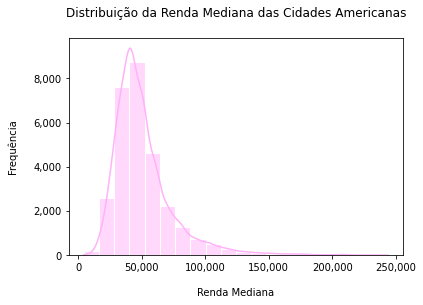

In [0]:
#verificar graficamente a distribuição de renda mediana

grafico = sns.histplot(
    silver_dimensao_renda_mediana["renda_mediana"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nRenda Mediana", ylabel="Frequência\n", title="Distribuição da Renda Mediana das Cidades Americanas\n"
)

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


Com o auxílio do histograma dos dados, podemos verificar que os dados parecem estar concentrados ao redor de R$ 50.000, assimétricos à direita.

##### **2.2.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_renda_mediana_spark.write.mode("overwrite").saveAsTable("silver.dimensao_renda_mediana")

##### **2.2.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE silver.dimensao_renda_mediana ALTER COLUMN cidade COMMENT 'Cidade e estado';
ALTER TABLE silver.dimensao_renda_mediana ALTER COLUMN renda_mediana COMMENT 'Renda mediana domiciliar';
ALTER TABLE silver.dimensao_renda_mediana ALTER COLUMN quartil_renda_mediana COMMENT 'Renda mediana segregada por quartil';

DESCRIBE EXTENDED silver.dimensao_renda_mediana;

col_name,data_type,comment
cidade,string,Cidade e estado
renda_mediana,double,Renda mediana domiciliar
quartil_renda_mediana,string,Renda mediana segregada por quartil
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,silver,
Table,dimensao_renda_mediana,
Created Time,Fri Apr 11 14:06:33 UTC 2025,
Last Access,UNKNOWN,


#### **2.3 - Tabela Dimensão 2 - Percentual de pessoas abaixo da linha da pobreza por cidade**

##### **2.3.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_linha_pobreza = spark.table("bronze.dimensao_linha_pobreza").toPandas()

silver_dimensao_linha_pobreza = dimensao_linha_pobreza.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_linha_pobreza.columns,
    "Tipo": silver_dimensao_linha_pobreza.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_linha_pobreza.isnull().sum(),
    "Valores Únicos": silver_dimensao_linha_pobreza.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Percentual da População Abaixo da Linha da Pobreza':\n\n{tabela}")


Informações da tabela 'Percentual da População Abaixo da Linha da Pobreza':

╒═════════════════╤════════╤═════════════════╤══════════════════╕
│     Coluna      │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞═════════════════╪════════╪═════════════════╪══════════════════╡
│ geographic_area │ object │        0        │        51        │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│      city       │ object │        0        │      24255       │
├─────────────────┼────────┼─────────────────┼──────────────────┤
│  poverty_rate   │ object │        0        │       771        │
╘═════════════════╧════════╧═════════════════╧══════════════════╛


Não foram identificados valores nulos na tabela.

##### **2.3.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

Após a verificação geral das informações da tabela dimensão 2, serão performadas as seguintes transformações para a subida ao nível silver:

- Alteração do nome da coluna "poverty_rate" para "indice_pobreza", de modo a facilitar a referência ao longo do código;

- Padronização dos nomes das cidades, a exemplo do realizado para a tabela fato;

- Inclusão da variável "cidade", unificando a variável "city" com a variável "geographic area", de modo a simplificar os joins que serão realizados a seguir;

- Conversão dos valores da coluna "indice_pobreza" para o formato numérico, de modo a permitir as operações que serão realizadas em seguida.

In [0]:
#renomear colunas para facilitar a referência

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.rename(
    columns={"poverty_rate": "indice_pobreza"}
)

#padronização do nome das cidades

silver_dimensao_linha_pobreza = padronizar_cidades(
    silver_dimensao_linha_pobreza, "city", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_linha_pobreza = converter_numerico(
    silver_dimensao_linha_pobreza, "indice_pobreza"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_linha_pobreza["cidade"] = (
    silver_dimensao_linha_pobreza["city"]
    + ", "
    + silver_dimensao_linha_pobreza["geographic_area"]
)

#verificar se há registros duplicados

silver_dimensao_linha_pobreza[silver_dimensao_linha_pobreza["cidade"].duplicated()]

,geographic_area,city,indice_pobreza,cidade
544,AL,Union,48.4,"Union, AL"
1032,AZ,Cottonwood,19.9,"Cottonwood, AZ"
1253,AZ,St. Johns,46.4,"St. Johns, AZ"
1388,AZ,Young,22.5,"Young, AZ"
1726,AR,Midway,10.2,"Midway, AR"
...,...,...,...,...
26015,IN,Highland,2.2,"Highland, IN"
28281,KY,Fairview,6.6,"Fairview, KY"
28606,KY,Union,37.0,"Union, KY"
28630,KY,Westwood,5.9,"Westwood, KY"


Mesmo após os tratamentos, foram verificados 83 registros duplicados, de modo que faremos o agrupamento da tabela pela média entre os valores. Cabe pontuar, ainda, que a medida "indice_pobreza" pode tornar sua interpretação desafiadora, uma vez que não há referência clara de quais valores são altos ou baixos. Nesse sentido, optamos por categorizar os dados em quartis.

In [0]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.groupby(["cidade"], dropna=False)["indice_pobreza"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_linha_pobreza = categorizar_quartis(silver_dimensao_linha_pobreza, "indice_pobreza")

#tabela final

silver_dimensao_linha_pobreza = silver_dimensao_linha_pobreza.rename(columns={"Categoria": "quartil_linha_pobreza"})

silver_dimensao_linha_pobreza_spark = spark.createDataFrame(silver_dimensao_linha_pobreza)

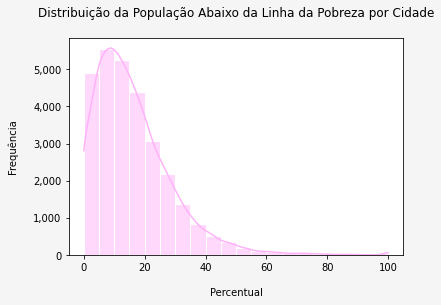

In [0]:
#verificar graficamente a distribuição da população abaixo da linha da pobreza

grafico = sns.histplot(
    silver_dimensao_linha_pobreza["indice_pobreza"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nPercentual", ylabel="Frequência\n", title="Distribuição da População Abaixo da Linha da Pobreza por Cidade\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()


Com o auxílio do histograma dos dados, podemos verificar que os dados parecem estar concentrados entre 0% e 20%, assimétricos à direita.

##### **2.3.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_linha_pobreza_spark.write.mode("overwrite").saveAsTable("silver.dimensao_linha_pobreza")

##### **2.3.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE silver.dimensao_linha_pobreza ALTER COLUMN cidade COMMENT 'Cidade e estado';
ALTER TABLE silver.dimensao_linha_pobreza ALTER COLUMN indice_pobreza COMMENT 'Percentual de pessoas que vivem abaixo da linha da pobreza';
ALTER TABLE silver.dimensao_linha_pobreza ALTER COLUMN quartil_linha_pobreza COMMENT 'Percentual de pessoas que vivem abaixo da linha da pobreza segregado por quartil';

DESCRIBE EXTENDED silver.dimensao_linha_pobreza;

col_name,data_type,comment
cidade,string,Cidade e estado
indice_pobreza,double,Percentual de pessoas que vivem abaixo da linha da pobreza
quartil_linha_pobreza,string,Percentual de pessoas que vivem abaixo da linha da pobreza segregado por quartil
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,silver,
Table,dimensao_linha_pobreza,
Created Time,Fri Apr 11 14:06:56 UTC 2025,
Last Access,UNKNOWN,


#### **2.4 - Tabela Dimensão 3 - Percentual de pessoas acima de 25 anos que completaram o ensino médio por cidade**

##### **2.4.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_escolaridade = spark.table("bronze.dimensao_escolaridade").toPandas()

silver_dimensao_escolaridade = dimensao_escolaridade.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_escolaridade.columns,
    "Tipo": silver_dimensao_escolaridade.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_escolaridade.isnull().sum(),
    "Valores Únicos": silver_dimensao_escolaridade.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'População que Completou o Ensino Médio':\n\n{tabela}")


Informações da tabela 'População que Completou o Ensino Médio':

╒══════════════════════╤════════╤═════════════════╤══════════════════╕
│        Coluna        │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞══════════════════════╪════════╪═════════════════╪══════════════════╡
│   geographic_area    │ object │        0        │        51        │
├──────────────────────┼────────┼─────────────────┼──────────────────┤
│         city         │ object │        0        │      24255       │
├──────────────────────┼────────┼─────────────────┼──────────────────┤
│ percent_completed_hs │ object │        0        │       728        │
╘══════════════════════╧════════╧═════════════════╧══════════════════╛


Não foram identificados valores nulos na tabela.

##### **2.4.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

Após a verificação geral das informações da tabela dimensão 3, serão performadas as seguintes transformações para a subida ao nível silver:

- Alteração do nome da coluna "percent_completed_hs" para "percentual_em", de modo a facilitar a referência ao longo do código;

- Padronização dos nomes das cidades, a exemplo do realizado para a tabela fato;

- Inclusão da variável "cidade", unificando a variável "city" com a variável "geographic area", de modo a simplificar os joins que serão realizados a seguir;

- Conversão dos valores da coluna "percentual_em" para o formato numérico, de modo a permitir as operações que serão realizadas em seguida.

In [0]:
#renomear colunas para facilitar a referência

silver_dimensao_escolaridade = silver_dimensao_escolaridade.rename(
    columns={"percent_completed_hs": "percentual_em"}
)

#padronização do nome das cidades

silver_dimensao_escolaridade = padronizar_cidades(
    silver_dimensao_escolaridade, "city", ["city", "CDP", "town"]
)

#converter a coluna de interesse para o formato numérico

silver_dimensao_escolaridade = converter_numerico(
    silver_dimensao_escolaridade, "percentual_em"
)

#concatenação dos nomes de cidades e estados

silver_dimensao_escolaridade["cidade"] = (
    silver_dimensao_escolaridade["city"]
    + ", "
    + silver_dimensao_escolaridade["geographic_area"]
)

#verificar se há registros duplicados

silver_dimensao_escolaridade[silver_dimensao_escolaridade["cidade"].duplicated()]

,geographic_area,city,percentual_em,cidade
544,AL,Union,66.1,"Union, AL"
1032,AZ,Cottonwood,84.9,"Cottonwood, AZ"
1253,AZ,St. Johns,75.3,"St. Johns, AZ"
1388,AZ,Young,82.7,"Young, AZ"
1726,AR,Midway,87.7,"Midway, AR"
...,...,...,...,...
26015,IN,Highland,97.5,"Highland, IN"
28281,KY,Fairview,89.0,"Fairview, KY"
28606,KY,Union,80.3,"Union, KY"
28630,KY,Westwood,98.3,"Westwood, KY"


Mesmo após os tratamentos, foram verificados 83 registros duplicados, de modo que faremos o agrupamento da tabela pela média entre os valores. Cabe pontuar, ainda, que a medida "renda_mediana" pode tornar sua interpretação desafiadora, uma vez que não há referência clara de quais valores são altos ou baixos. Nesse sentido, optamos por categorizar os dados em quartis.

In [0]:
##agrupar resultados duplicados pela média entre eles

silver_dimensao_escolaridade = silver_dimensao_escolaridade.groupby(["cidade"], dropna=False)["percentual_em"].mean(numeric_only=True).reset_index()

#separar os dados em quartis

silver_dimensao_escolaridade = categorizar_quartis(silver_dimensao_escolaridade, "percentual_em")

#tabela final

silver_dimensao_escolaridade = silver_dimensao_escolaridade.rename(columns={"Categoria": "quartil_percentual_em"})

silver_dimensao_escolaridade_spark = spark.createDataFrame(silver_dimensao_escolaridade)

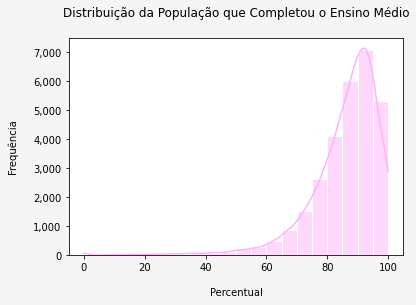

In [0]:
#verificar graficamente a distribuição da população que completou o Ensino Médio

grafico = sns.histplot(
    silver_dimensao_escolaridade["percentual_em"],
    bins=20,
    color="#ffb2f9",
    edgecolor="#FFFFFF",
    kde=True,
)

grafico.set(
    xlabel="\nPercentual", ylabel="Frequência\n", title="Distribuição da População que Completou o Ensino Médio\n"
)

plt.gcf().set_facecolor("whitesmoke")

grafico.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
grafico.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

plt.show()

Com o auxílio do histograma dos dados, podemos verificar que os dados parecem estar concentrados entre 80% e 100%, assimétricos à esquerda.

##### **2.4.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_escolaridade_spark.write.mode("overwrite").saveAsTable("silver.dimensao_escolaridade")

##### **2.4.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE silver.dimensao_escolaridade ALTER COLUMN cidade COMMENT 'Cidade e estado';
ALTER TABLE silver.dimensao_escolaridade ALTER COLUMN percentual_em COMMENT 'Percentual de pessoas acima de 25 anos que completaram o ensino médio';
ALTER TABLE silver.dimensao_escolaridade ALTER COLUMN quartil_percentual_em COMMENT 'Percentual de pessoas acima de 25 anos que completaram o ensino médio segregado por quartil';

DESCRIBE EXTENDED silver.dimensao_escolaridade;

col_name,data_type,comment
cidade,string,Cidade e estado
percentual_em,double,Percentual de pessoas acima de 25 anos que completaram o ensino médio
quartil_percentual_em,string,Percentual de pessoas acima de 25 anos que completaram o ensino médio segregado por quartil
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,silver,
Table,dimensao_escolaridade,
Created Time,Fri Apr 11 14:07:21 UTC 2025,
Last Access,UNKNOWN,


#### **2.5 - Tabela Dimensão 4 - Distribuição percentual de raças por cidade**

##### **2.5.1 - Extrair a tabela do schema bronze e performar a análise exploratória**

In [0]:
dimensao_percentual_racas = spark.table("bronze.dimensao_percentual_racas").toPandas()

silver_dimensao_percentual_racas = dimensao_percentual_racas.copy()

info = pd.DataFrame({
    "Coluna": silver_dimensao_percentual_racas.columns,
    "Tipo": silver_dimensao_percentual_racas.dtypes.astype(str),
    "Valores Nulos": silver_dimensao_percentual_racas.isnull().sum(),
    "Valores Únicos": silver_dimensao_percentual_racas.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Distribuição de Raças das Cidades Americanas':\n\n{tabela}")


Informações da tabela 'Distribuição de Raças das Cidades Americanas':

╒═══════════════════════╤════════╤═════════════════╤══════════════════╕
│        Coluna         │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞═══════════════════════╪════════╪═════════════════╪══════════════════╡
│    geographic_area    │ object │        0        │        51        │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│         city          │ object │        0        │      24219       │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│      share_white      │ object │        0        │       997        │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│      share_black      │ object │        0        │       926        │
├───────────────────────┼────────┼─────────────────┼──────────────────┤
│ share_native_american │ object │        0        │       628        │
├───────────────────────┼────────┼─────────────────┼────────────

Não foram identificados valores nulos na tabela.

##### **2.5.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

Após a verificação geral das informações da tabela dimensão 4, serão performadas as seguintes transformações para a subida ao nível silver:

- Alteração dos nomes das colunas que contêm o percentual por raças, de modo a facilitar a referência ao longo do código;

- Padronização dos nomes das cidades, a exemplo do realizado para a tabela fato;

- Inclusão da variável "cidade", unificando a variável "city" com a variável "geographic area", de modo a simplificar os joins que serão realizados a seguir;

- Conversão dos valores das colunas de percentual por raça para o formato numérico, de modo a permitir as operações que serão realizadas em seguida.

In [0]:
# renomear colunas para facilitar a referência

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.rename(
    columns={
        "share_white": "percentual_brancos",
        "share_black": "percentual_pretos",
        "share_native_american": "percentual_indigenas",
        "share_asian": "percentual_asiaticos",
        "share_hispanic": "percentual_hispanicos",
    }
)

# padronização do nome das cidades

silver_dimensao_percentual_racas = padronizar_cidades(silver_dimensao_percentual_racas, "city", ["city", "CDP", "town"])

# converter a coluna de interesse para o formato numérico

colunas = silver_dimensao_percentual_racas.columns.drop(["geographic_area", "city"])

for coluna in colunas:
    silver_dimensao_percentual_racas = converter_numerico(
        silver_dimensao_percentual_racas, coluna
    )

# concatenação dos nomes de cidades e estados

silver_dimensao_percentual_racas["cidade"] = (
    silver_dimensao_percentual_racas["city"]
    + ", "
    + silver_dimensao_percentual_racas["geographic_area"]
)

# verificar se há registros duplicados

silver_dimensao_percentual_racas[silver_dimensao_percentual_racas["cidade"].duplicated()]

,geographic_area,city,percentual_brancos,percentual_pretos,percentual_indigenas,percentual_asiaticos,percentual_hispanicos,cidade
537,AL,Union,9.1,90.6,0.0,0.0,0.5,"Union, AL"
1025,AZ,Cottonwood,83.6,0.8,1.8,0.9,22.8,"Cottonwood, AZ"
1246,AZ,St. Johns,2.9,0.2,95.0,0.0,4.0,"St. Johns, AZ"
1381,AZ,Young,73.3,4.3,1.4,2.8,33.0,"Young, AZ"
1720,AR,Midway,97.9,0.0,0.3,0.8,0.8,"Midway, AR"
...,...,...,...,...,...,...,...,...
25969,IN,Highland,96.1,1.3,0.0,1.2,0.8,"Highland, IN"
28228,KY,Fairview,100.0,0.0,0.0,0.0,0.0,"Fairview, KY"
28548,KY,Union,91.2,5.5,0.5,0.1,1.3,"Union, KY"
28571,KY,Westwood,88.8,5.5,0.2,2.2,2.8,"Westwood, KY"


Mesmo após os tratamentos, foram verificados 83 registros duplicados, de modo que faremos o agrupamento da tabela pela média entre os valores. Cabe pontuar, ainda, que a medida "renda_mediana" pode tornar sua interpretação desafiadora, uma vez que não há referência clara de quais valores são altos ou baixos. Nesse sentido, optamos por categorizar os dados em quartis.

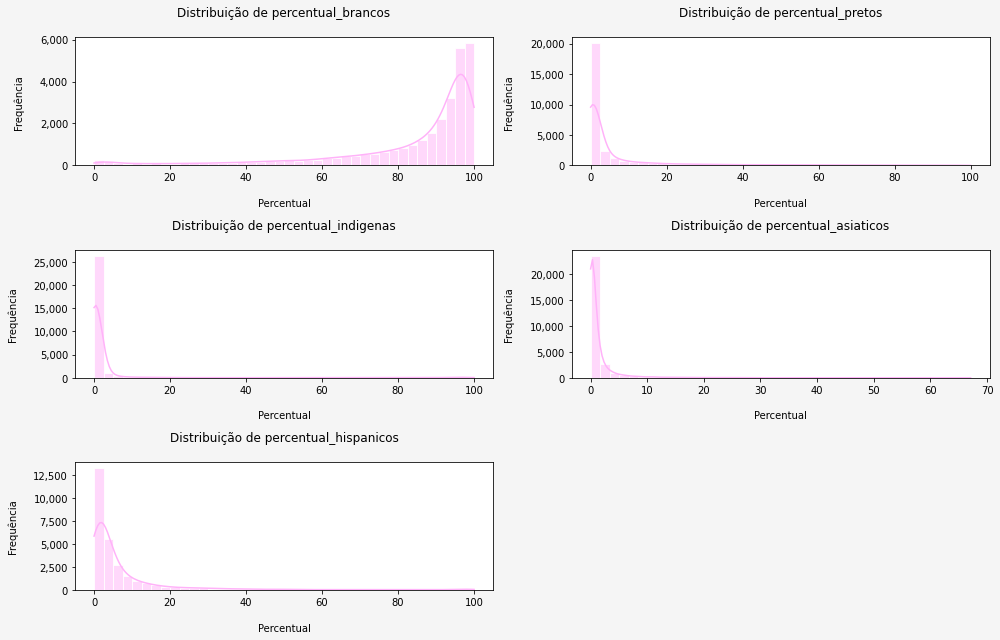

In [0]:
#agrupar resultados duplicados pela média entre eles

silver_dimensao_percentual_racas = silver_dimensao_percentual_racas.groupby(["cidade"], dropna=False)[colunas].mean(numeric_only=True).reset_index()

silver_dimensao_percentual_racas_spark = spark.createDataFrame(silver_dimensao_percentual_racas)

#verificar graficamente a distribuição da população por raças

num_rows = (len(colunas) // 2) + (len(colunas) % 2)
figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows * 3))
eixos = eixos.flatten()

for i, coluna in enumerate(colunas):
    sns.histplot(silver_dimensao_percentual_racas[coluna], bins=40, ax=eixos[i], color="#ffb2f9", edgecolor="#FFFFFF", kde=True)
    eixos[i].set_title(f"Distribuição de {coluna}\n")
    eixos[i].set_xlabel("\nPercentual")
    eixos[i].set_ylabel("Frequência\n")
    eixos[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    eixos[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

for j in range(i + 1, len(eixos)):
    eixos[j].set_visible(False)

figura.set_facecolor("whitesmoke")
plt.tight_layout()
plt.show()

Com o auxílio dos histogramas acima, confirma-se a suspeita inicial de uma população majoritariamente branca, única variável com comportamento assimétrico à esquerda.

##### **2.5.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_percentual_racas_spark.write.mode("overwrite").saveAsTable("silver.dimensao_percentual_racas")

##### **2.5.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE silver.dimensao_percentual_racas ALTER COLUMN cidade COMMENT 'Cidade e estado';
ALTER TABLE silver.dimensao_percentual_racas ALTER COLUMN percentual_brancos COMMENT 'Percentual de pessoas identificadas como brancas';
ALTER TABLE silver.dimensao_percentual_racas ALTER COLUMN percentual_pretos COMMENT 'Percentual de pessoas identificadas como pretas';
ALTER TABLE silver.dimensao_percentual_racas ALTER COLUMN percentual_indigenas COMMENT 'Percentual de pessoas identificadas como indígenas';
ALTER TABLE silver.dimensao_percentual_racas ALTER COLUMN percentual_asiaticos COMMENT 'Percentual de pessoas identificadas como asiáticas';
ALTER TABLE silver.dimensao_percentual_racas ALTER COLUMN percentual_hispanicos COMMENT 'Percentual de pessoas identificadas como hispânicas';

DESCRIBE EXTENDED silver.dimensao_percentual_racas

col_name,data_type,comment
cidade,string,Cidade e estado
percentual_brancos,double,Percentual de pessoas identificadas como brancas
percentual_pretos,double,Percentual de pessoas identificadas como pretas
percentual_indigenas,double,Percentual de pessoas identificadas como indígenas
percentual_asiaticos,double,Percentual de pessoas identificadas como asiáticas
percentual_hispanicos,double,Percentual de pessoas identificadas como hispânicas
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,silver,


#### **2.6 - Tabela Dimensão 5 - População por cidade americana**

##### **2.6.1 - Extrair as tabelas do schema bronze**

In [0]:
codigos_cidades = spark.table("bronze.codigos_cidades").toPandas()

dimensao_populacao = spark.table("bronze.dimensao_populacao").toPandas()

codigos_cidades = codigos_cidades.copy()

info = pd.DataFrame({
    "Coluna": codigos_cidades.columns,
    "Tipo": codigos_cidades.dtypes.astype(str),
    "Valores Nulos": codigos_cidades.isnull().sum(),
    "Valores Únicos": codigos_cidades.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Códigos Cidades':\n\n{tabela}")

dimensao_populacao = dimensao_populacao.copy()

info = pd.DataFrame({
    "Coluna": dimensao_populacao.columns,
    "Tipo": dimensao_populacao.dtypes.astype(str),
    "Valores Nulos": dimensao_populacao.isnull().sum(),
    "Valores Únicos": dimensao_populacao.nunique()
})

tabela = tabulate(info, headers="keys", tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print(f"\nInformações da tabela 'Esimativa de População por Cidade':\n\n{tabela}")


Informações da tabela 'Códigos Cidades':

╒════════════╤════════╤═════════════════╤══════════════════╕
│   Coluna   │  Tipo  │  Valores Nulos  │  Valores Únicos  │
╞════════════╪════════╪═════════════════╪══════════════════╡
│   state    │ object │        0        │        57        │
├────────────┼────────┼─────────────────┼──────────────────┤
│  statefp   │ int64  │        0        │        57        │
├────────────┼────────┼─────────────────┼──────────────────┤
│  countyfp  │ int64  │        0        │       331        │
├────────────┼────────┼─────────────────┼──────────────────┤
│  countyns  │ int64  │        0        │       3235       │
├────────────┼────────┼─────────────────┼──────────────────┤
│ countyname │ object │        0        │       1970       │
├────────────┼────────┼─────────────────┼──────────────────┤
│  classfp   │ object │        0        │        5         │
├────────────┼────────┼─────────────────┼──────────────────┤
│  funcstat  │ object │        0        │ 

Com base nas tabelas geradas acima, é possível verificar que não há ocorrência de valores nulos. O formato das variáveis "popestimate" também parece estar adequado, de modo que não será necessário converter os valores. Como não há a sigla do estado na tabela "dimensao_populacao", será necessário enriquecê-la com a tabela "codigos_cidades".

Tendo em vista a distribuição das datas citada anteriormente, escolheu-se utilizar a estimativa do ano de 2016 para a sequência deste trabalho.

##### **2.6.2 - Realizar as transformações necessárias nas tabelas para a subida no schema silver**

No passo a seguir, são performadas as seguintes transformações nos dados:

- Alteração do nome de colunas, de modo a facilitar a referência ao longo do código;

- Padronização dos nomes das cidades, a exemplo do realizado para a tabela fato;

- Inclusão da variável "cidade", unificando a variável "city" com a variável "geographic area", de modo a simplificar os joins que serão realizados a seguir.


In [0]:
codigos_cidades = codigos_cidades.rename(
    columns={"state": "estado", "statefp": "codigo_estado"}
)
codigos_cidades = codigos_cidades[
    ["estado", "codigo_estado"]
].drop_duplicates(subset=["estado", "codigo_estado"])

silver_dimensao_populacao = dimensao_populacao.copy()

silver_dimensao_populacao = silver_dimensao_populacao.merge(
    codigos_cidades, left_on="state", right_on="codigo_estado", validate="m:1"
)

silver_dimensao_populacao = silver_dimensao_populacao.rename(columns={"popestimate2016": "estimativa_populacao"})

silver_dimensao_populacao = silver_dimensao_populacao[
    ["estado", "name", "estimativa_populacao"]
]

silver_dimensao_populacao = padronizar_cidades(
    silver_dimensao_populacao, "name", ["city", "CDP", "town"]
)

silver_dimensao_populacao["cidade"] = silver_dimensao_populacao["name"] + ", " + silver_dimensao_populacao["estado"]

silver_dimensao_populacao = silver_dimensao_populacao.drop_duplicates()

silver_dimensao_populacao = silver_dimensao_populacao.groupby(["cidade"], dropna=False)["estimativa_populacao"].mean(numeric_only=True).reset_index()

silver_dimensao_populacao_spark = spark.createDataFrame(silver_dimensao_populacao)

##### **2.6.3 - Carregar a tabela trabalhada no schema silver**

In [0]:
silver_dimensao_populacao_spark.write.mode("overwrite").saveAsTable("silver.dimensao_populacao")

##### **2.6.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE silver.dimensao_populacao ALTER COLUMN cidade COMMENT 'Cidade e estado da ocorrência';
ALTER TABLE silver.dimensao_populacao ALTER COLUMN estimativa_populacao COMMENT 'População estimada da cidade conforme dados de 2016';

DESCRIBE EXTENDED silver.dimensao_populacao;

col_name,data_type,comment
cidade,string,Cidade e estado da ocorrência
estimativa_populacao,double,População estimada da cidade conforme dados de 2016
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,silver,
Table,dimensao_populacao,
Created Time,Fri Apr 11 14:08:25 UTC 2025,
Last Access,UNKNOWN,
Created By,Spark 3.3.2,


### **3 - ETL para criação das tabelas nível gold**

#### **3.1 - Tabela Gold 1 - Base de homicídios policiais enriquecidas com dados das cidades de ocorrência**

##### **3.1.1 - Extrair as tabelas do schema silver**

In [0]:
silver_fato = spark.table("silver.fato").toPandas()

silver_dimensao_escolaridade = spark.table("silver.dimensao_escolaridade").toPandas()

silver_dimensao_linha_pobreza = spark.table("silver.dimensao_linha_pobreza").toPandas()

silver_dimensao_percentual_racas = spark.table("silver.dimensao_percentual_racas").toPandas()

silver_dimensao_populacao = spark.table("silver.dimensao_populacao").toPandas()

##### **3.1.2 - Realizar as transformações necessárias na tabela para a subida no schema silver**

Na primeira tabela gold, o objetivo é construir uma base única de informações das tabelas fato e dimensão, de modo a facilitar a visualização dos dados e a análise das tabelas para a resposta aos objetivos postos no arquivo **README**. Nesse sentido, performamos o merge entre as tabelas do nível silver.

In [0]:
fato_homicidios_cidades = (
    silver_fato.merge(
        silver_dimensao_renda_mediana,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_escolaridade,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_linha_pobreza,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_percentual_racas,
        on=["cidade"],
        validate="m:1",
        how="left",
    )
    .merge(
        silver_dimensao_populacao, 
        on=["cidade"], 
        validate="m:1", 
        how="left")
)

#verificando o resultado

info = [
    [coluna, fato_homicidios_cidades[coluna].dtype, fato_homicidios_cidades[coluna].isnull().sum()]
    for coluna in fato_homicidios_cidades.columns
]

headers = ["Coluna", "Tipo de Dado",  "Valores Nulos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center"))

print("\nAnálise da tabela fato - Nível gold\n")
print(tabela)


Análise da tabela fato - Nível gold

╒═══════════════════════╤════════════════╤═════════════════╕
│        Coluna         │  Tipo de Dado  │  Valores Nulos  │
╞═══════════════════════╪════════════════╪═════════════════╡
│          id           │     int64      │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│          mes          │     int64      │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│          ano          │     int64      │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│   categoria_armado    │     object     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│         raca          │     object     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│        cidade         │     object     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│     renda_mediana     │    float64     │     

Após o merge das tabelas, é possível verificar valores nulos das colunas oriundas das tabelas dimensão, o que pode indicar erro no preenchimento dos nomes da tabela fato crua. Sem um identificador claro das cidades que não esteja em formato string, não conseguimos verificar os registros inconsistentes.

Desse modo, por entendermos que esses registros não são capazes de contribuir para a análise desenhada no objetivo, optamos por retirá-los da base.

In [0]:
fato_homicidios_cidades = fato_homicidios_cidades.dropna()

fato_homicidios_cidades_spark = spark.createDataFrame(fato_homicidios_cidades)

##### **3.1.3 - Carregar a tabela trabalhada no schema gold**

In [0]:
fato_homicidios_cidades_spark.write.mode("overwrite").saveAsTable("gold.fato_homicidios_cidades")

Cabe pontuar que não foi criado catálogo de dados específico para essa tabela, tendo em vista que mantém as mesmas colunas descritas no nível silver.

#### **3.2 - Tabela Gold 2 - Homicídios por Mil Habitantes**

##### **3.2.1 - Extrair a tabela "fato_homicidios_cidades" do schema gold**

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

##### **3.2.2 - Realizar as transformações necessárias na tabela para a subida no schema gold**

Na segunda tabela gold, o objetivo é verificar a quantidade de homicídios a cada mil habitantes por cidade. Nesse sentido, efetuou-se a transformação da tabela "fato_homicidios_cidades" para um formato que facilite a geração dos gráficos na sequência do trabalho.

In [0]:
fato_homicidios_mil_habitantes = (
    fato_homicidios_cidades.groupby("cidade")["id"]
    .count()
    .reset_index(name="quantidade")
    .sort_values(by="quantidade", ascending=False)
    .merge(
        fato_homicidios_cidades[
            [
                "cidade",
                "estimativa_populacao",
                "percentual_brancos",
                "percentual_pretos",
                "percentual_hispanicos",
                "percentual_asiaticos",
                "percentual_indigenas"
            ]
        ].drop_duplicates(),
        validate="m:1",
        how="left",
        on="cidade",
    )
)

fato_homicidios_mil_habitantes["mortes_mil_habitantes"] = (
    fato_homicidios_mil_habitantes["quantidade"] / fato_homicidios_mil_habitantes["estimativa_populacao"] * 1000
)

info = [
    [coluna, fato_homicidios_mil_habitantes[coluna].dtype, fato_homicidios_mil_habitantes[coluna].isnull().sum()]
    for coluna in fato_homicidios_mil_habitantes.columns
]

headers = ["Coluna", "Tipo de Dado",  "Valores Nulos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center"))

print("\nAnálise da tabela fato - Homicídios por Mil Habitantes\n")
print(tabela)




Análise da tabela fato - Homicídios por Mil Habitantes

╒═══════════════════════╤════════════════╤═════════════════╕
│        Coluna         │  Tipo de Dado  │  Valores Nulos  │
╞═══════════════════════╪════════════════╪═════════════════╡
│        cidade         │     object     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│      quantidade       │     int64      │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│ estimativa_populacao  │    float64     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│  percentual_brancos   │    float64     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│   percentual_pretos   │    float64     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│ percentual_hispanicos │    float64     │        0        │
├───────────────────────┼────────────────┼─────────────────┤
│ percentual_asiaticos  │   

Conforme esperado, dado que o merge ocorreu entre subsets da mesma tabela, não verificamos ocorrência de valores nulos.

In [0]:
fato_homicidios_mil_habitantes_spark = spark.createDataFrame(fato_homicidios_mil_habitantes)

##### **3.2.3 - Carregar a tabela trabalhada no schema gold**

In [0]:
fato_homicidios_mil_habitantes_spark.write.mode("overwrite").saveAsTable("gold.fato_homicidios_mil_habitantes")

##### **3.2.4 - Criação do catálogo de dados da tabela carregada**

In [0]:
%sql

ALTER TABLE gold.fato_homicidios_mil_habitantes ALTER COLUMN mortes_mil_habitantes COMMENT 'Mortes por mil habitantes de cada cidade';

DESCRIBE EXTENDED gold.fato_homicidios_mil_habitantes

col_name,data_type,comment
cidade,string,null
quantidade,bigint,null
estimativa_populacao,double,null
percentual_brancos,double,null
percentual_pretos,double,null
percentual_hispanicos,double,null
percentual_asiaticos,double,null
percentual_indigenas,double,null
mortes_mil_habitantes,double,Mortes por mil habitantes de cada cidade
,,


#### **3.3 - Tabela Gold 3 - Índice de vítimas por raça**

##### **3.3.1 - Extrair a tabela "fato_homicidios_cidades" do schema gold**

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

##### **3.3.2 - Realizar as transformações necessárias na tabela para a subida no schema gold**

Na terceira tabela gold, o objetivo é verificar a quantidade de vítimas por raça, de modo a procurar identificar se há diferença significativa no comportamento das categorias mapeadas neste estudo. Nesse sentido, efetuou-se a transformação da tabela "fato_homicidios_cidades" para, inicialmente, estimar a população absoluta de cada raça conforme percentuais já preenchidos na tabela. 

In [0]:
colunas = ["percentual_brancos", "percentual_pretos", "percentual_indigenas", "percentual_asiaticos", "percentual_hispanicos"]

for coluna in colunas:
    nome_coluna = "populacao_" + coluna.split("_")[1]
    fato_homicidios_cidades[nome_coluna] = round(fato_homicidios_cidades[coluna]/100 * fato_homicidios_cidades["estimativa_populacao"], 0)

fato_indice_obitos_raca = (
    fato_homicidios_cidades.groupby("raca")["id"]
    .count()
    .reset_index(name="quantidade")
    .sort_values(by="quantidade", ascending=False)
    .merge(fato_homicidios_cidades.groupby("raca")["id"]
    .sum()
    .reset_index(name="populacao_total"),
    validate="1:1",
    how="left",
    on="raca"
    )
)

info = [
    [coluna, fato_indice_obitos_raca[coluna].dtype, fato_indice_obitos_raca[coluna].isnull().sum()]
    for coluna in fato_indice_obitos_raca.columns
]

headers = ["Coluna", "Tipo de Dado",  "Valores Nulos"]
tabela = tabulate(info, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center"))

print("\nAnálise da tabela fato - Índice de Óbitos por Raça\n")
print(tabela)


Análise da tabela fato - Índice de Óbitos por Raça

╒═════════════════╤════════════════╤═════════════════╕
│     Coluna      │  Tipo de Dado  │  Valores Nulos  │
╞═════════════════╪════════════════╪═════════════════╡
│      raca       │     object     │        0        │
├─────────────────┼────────────────┼─────────────────┤
│   quantidade    │     int64      │        0        │
├─────────────────┼────────────────┼─────────────────┤
│ populacao_total │     int64      │        0        │
╘═════════════════╧════════════════╧═════════════════╛


Conforme esperado, dado que o merge ocorreu entre subsets da mesma tabela, não verificamos ocorrência de valores nulos.

In [0]:
fato_indice_obitos_raca_spark = spark.createDataFrame(fato_indice_obitos_raca)

##### **3.3.3 - Carregar a tabela trabalhada no schema gold**

In [0]:
fato_indice_obitos_raca_spark.write.mode("overwrite").saveAsTable("gold.fato_indice_obitos_raca")

In [0]:
%sql

ALTER TABLE gold.fato_indice_obitos_raca ALTER COLUMN quantidade COMMENT 'Quantidade de óbitos por raça';

DESCRIBE EXTENDED gold.fato_indice_obitos_raca

col_name,data_type,comment
raca,string,null
quantidade,bigint,Quantidade de óbitos por raça
populacao_total,bigint,null
,,
# Detailed Table Information,,
Catalog,spark_catalog,
Database,gold,
Table,fato_indice_obitos_raca,
Created Time,Fri Apr 11 14:09:05 UTC 2025,
Last Access,UNKNOWN,


##### **3.3.4 - Criação do catálogo de dados da tabela carregada**

### **4 - Criação de gráficos e tabelas de suporte para a análise dos resultados**

Ao longo do item 4, serão apresentadas tabelas e gráficos que servirão de suporte para as respostas às perguntas colocadas no objetivo do trabalho. Os comentários sobre as visualizações geradas são consolidadas no item 5.

#### **4.1 - Contagem de homicídios conforme renda mediana por quartil**

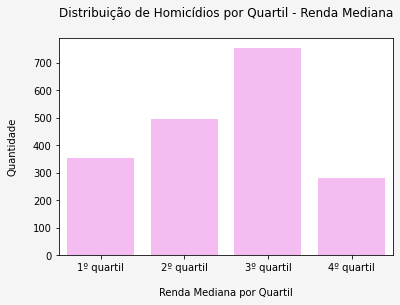

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

groupby = fato_homicidios_cidades.groupby("quartil_renda_mediana")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_renda_mediana")

grafico = sns.barplot(
    data=groupby,
    x="quartil_renda_mediana",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nRenda Mediana por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - Renda Mediana\n")

plt.show()

#### **4.2 - Contagem de homicídios conforme percentual da população abaixo da linha da pobreza por quartil**

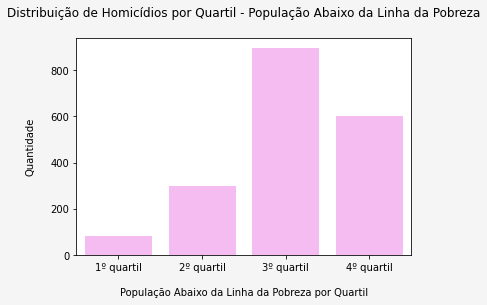

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

groupby = fato_homicidios_cidades.groupby("quartil_linha_pobreza")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_linha_pobreza")

grafico = sns.barplot(
    data=groupby,
    x="quartil_linha_pobreza",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nPopulação Abaixo da Linha da Pobreza por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População Abaixo da Linha da Pobreza\n")

plt.show()

#### **4.3 - Contagem de homicídios conforme percentual da população acima de 25 anos com Ensino Médio completo**

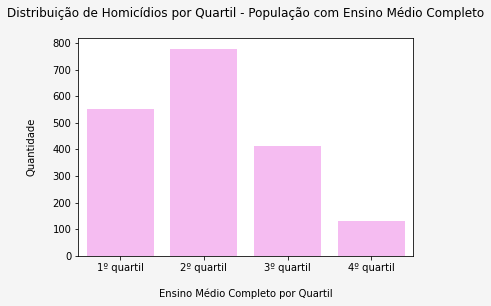

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

groupby = fato_homicidios_cidades.groupby("quartil_percentual_em")["id"].count().reset_index(name="Quantidade").sort_values(by="quartil_percentual_em")

grafico = sns.barplot(
    data=groupby,
    x="quartil_percentual_em",
    y="Quantidade",
    color="#ffb2f9"
)

grafico.figure = plt.gcf()
grafico.figure.set_facecolor("whitesmoke")
grafico.set_xlabel("\nEnsino Médio Completo por Quartil")
grafico.set_ylabel("Quantidade\n")
grafico.set_title("Distribuição de Homicídios por Quartil - População com Ensino Médio Completo\n")

plt.show()

#### **4.4 - Distribuição de homicídios por percentual de raça**

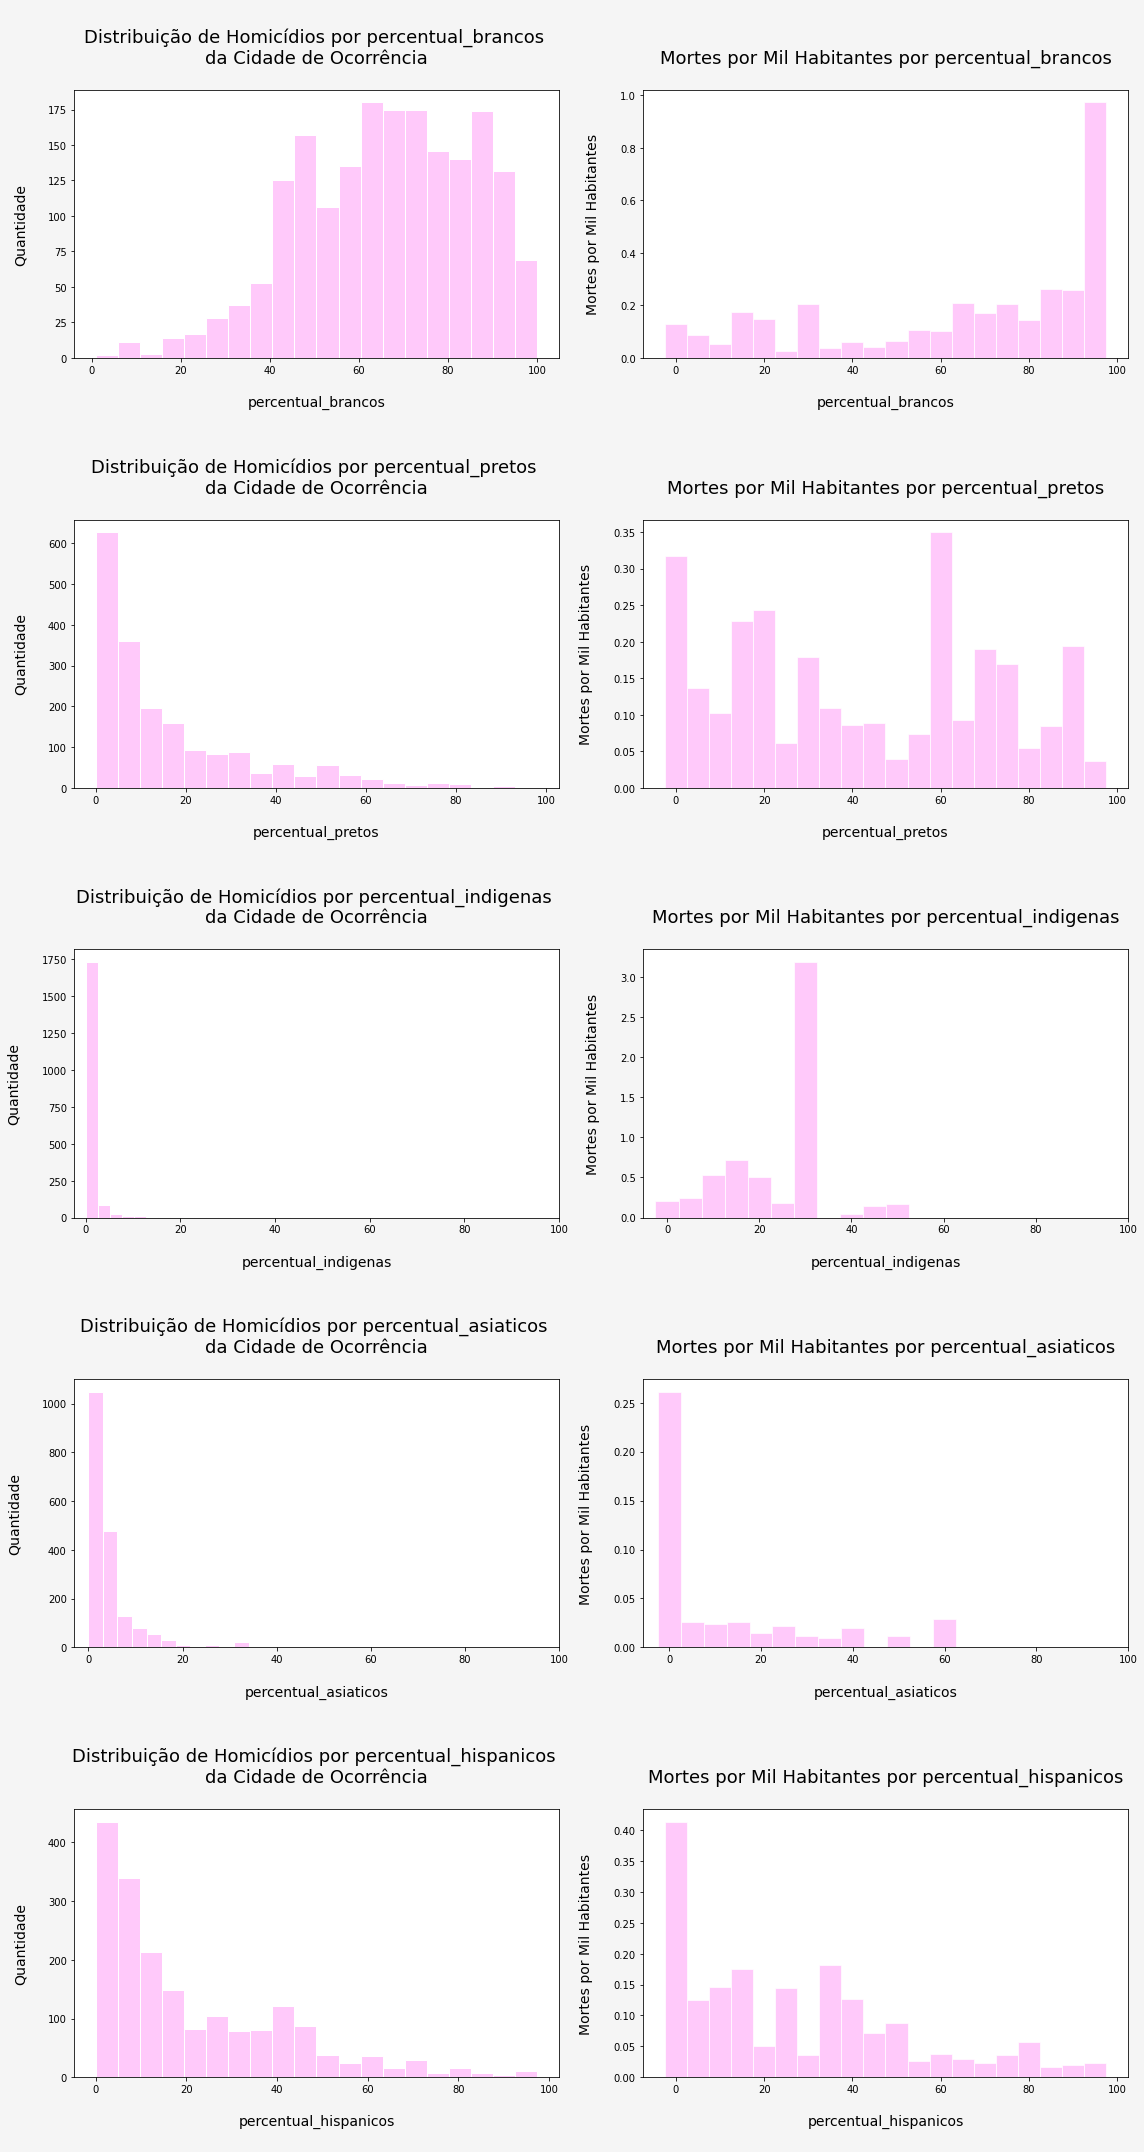

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()
fato_homicidios_mil_habitantes = spark.table("gold.fato_homicidios_mil_habitantes").toPandas()

num_rows = len(colunas)
figura, eixos = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, num_rows * 6))
eixos = eixos.flatten()

bins = np.arange(0, 101, 5)

for i, coluna in enumerate(colunas):
    sns.histplot(
        fato_homicidios_cidades[coluna],
        bins=20,
        color="#ffb2f9",
        edgecolor="#FFFFFF",
        alpha=0.7,
        ax=eixos[i * 2]
    )
    eixos[i * 2].set_xlabel(f"\n{coluna}\n", fontsize=14)
    eixos[i * 2].set_ylabel("Quantidade\n", fontsize=14)
    eixos[i * 2].set_title(f"\nDistribuição de Homicídios por {coluna} \nda Cidade de Ocorrência\n", fontsize=18)
    eixos[i * 2].set_xticks(np.arange(0, 101, 20))
    eixos[i * 2].set_xticklabels(np.arange(0, 101, 20))

    fato_homicidios_mil_habitantes["bins"] = pd.cut(
        fato_homicidios_mil_habitantes[coluna], 
        bins=bins, 
        labels=bins[:-1], 
        include_lowest=True,
    )

    grouped = fato_homicidios_mil_habitantes.groupby("bins", observed=False)["mortes_mil_habitantes"].mean().reset_index()
    grouped["bins"] = grouped["bins"].astype(int)

    eixos[i * 2 + 1].bar(grouped["bins"], grouped["mortes_mil_habitantes"], color="#ffb2f9", edgecolor="#FFFFFF", width=5, alpha=0.7)

    eixos[i * 2 + 1].set_xticks(np.arange(0, 101, 20))
    eixos[i * 2 + 1].set_xticklabels(np.arange(0, 101, 20))

    eixos[i * 2 + 1].set_xlabel(f"\n{coluna}\n", fontsize=14)
    eixos[i * 2 + 1].set_ylabel("Mortes por Mil Habitantes\n", fontsize=14)
    eixos[i * 2 + 1].set_title(f"\nMortes por Mil Habitantes por {coluna}\n", fontsize=18)

plt.tight_layout()
figura.set_facecolor("whitesmoke")
plt.show()


#### **4.5 - Índice de vítimas por raça**

In [0]:

fato_indice_obitos_raca = spark.table("gold.fato_indice_obitos_raca").toPandas()

fato_indice_obitos_raca["indice"] = fato_indice_obitos_raca["quantidade"] / fato_indice_obitos_raca["populacao_total"]

headers = ["Raça", "Quantidade", "População Total", "Índice"]
tabela = tabulate(fato_indice_obitos_raca, headers=headers, tablefmt="fancy_grid", showindex=False, colalign=("center", "center", "center", "center"))

print("\nAnálise do Índice de Óbitos por Raça\n")
print(tabela)


Análise do Índice de Óbitos por Raça

╒═══════════╤══════════════╤═══════════════════╤═════════════╕
│   Raça    │  Quantidade  │  População Total  │   Índice    │
╞═══════════╪══════════════╪═══════════════════╪═════════════╡
│  Branco   │     918      │      1269624      │ 0.000723049 │
├───────────┼──────────────┼───────────────────┼─────────────┤
│   Preto   │     519      │      720485       │ 0.000720348 │
├───────────┼──────────────┼───────────────────┼─────────────┤
│ Hispânico │     369      │      527853       │ 0.000699058 │
├───────────┼──────────────┼───────────────────┼─────────────┤
│ Asiático  │      31      │       45243       │ 0.000685189 │
├───────────┼──────────────┼───────────────────┼─────────────┤
│ Indígena  │      24      │       35869       │ 0.000669101 │
├───────────┼──────────────┼───────────────────┼─────────────┤
│  Outros   │      18      │       19659       │ 0.000915611 │
╘═══════════╧══════════════╧═══════════════════╧═════════════╛


#### **4.6 - Matriz de correlação da tabela "gold.fato_homicidios_cidades"**

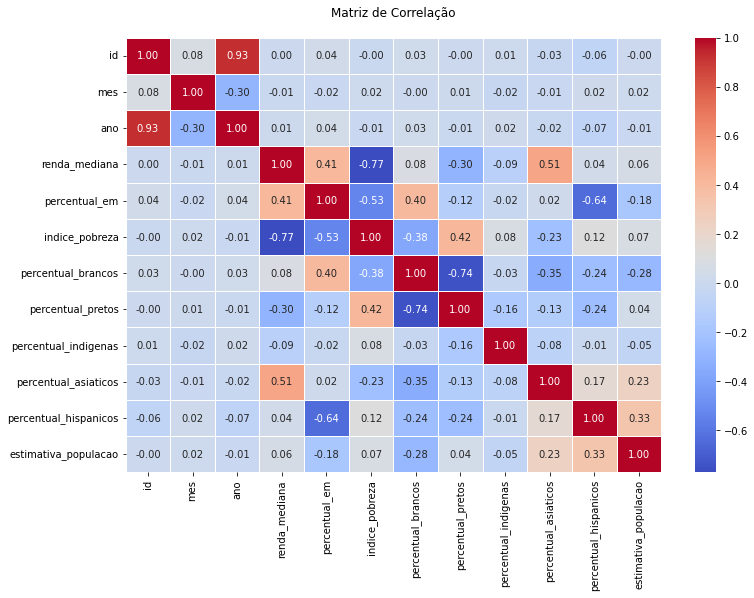

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

correlacao = fato_homicidios_cidades.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlação\n")

plt.show()

#### **4.7 - Geração de gráficos de ponto a partir da tabela "gold.fato_homicidios_cidades"**

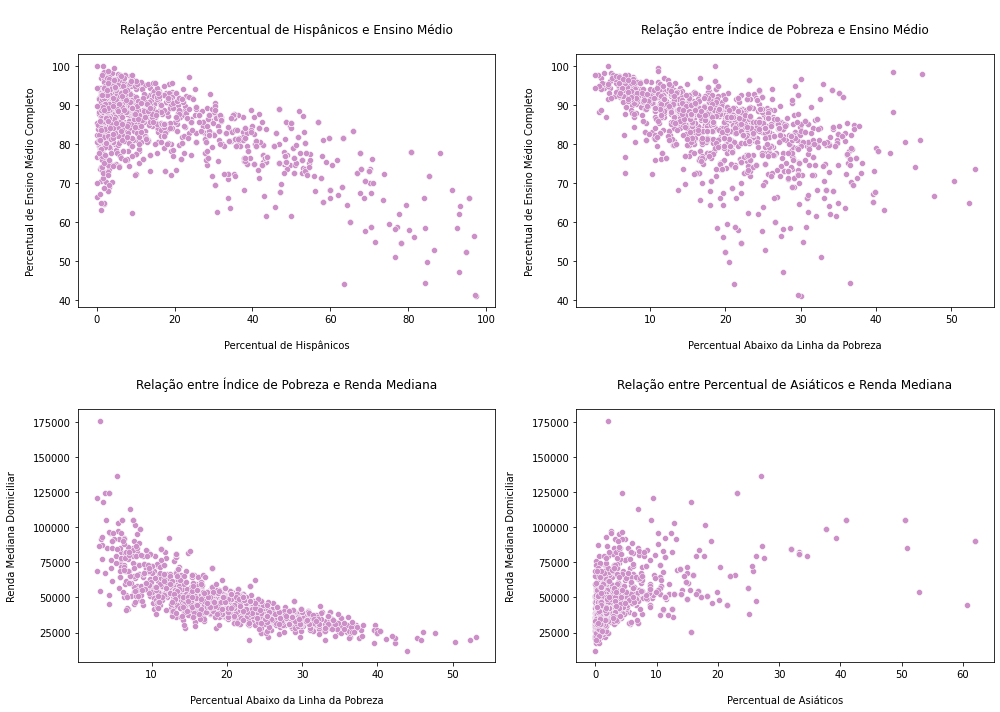

In [0]:
fato_homicidios_cidades = spark.table("gold.fato_homicidios_cidades").toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=fato_homicidios_cidades, x="percentual_hispanicos", y="percentual_em", color="#cc8fc7", ax=axes[0, 0])
axes[0, 0].set_xlabel("\nPercentual de Hispânicos")
axes[0, 0].set_ylabel("Percentual de Ensino Médio Completo\n")
axes[0, 0].set_title("\nRelação entre Percentual de Hispânicos e Ensino Médio\n")

sns.scatterplot(data=fato_homicidios_cidades, x="indice_pobreza", y="percentual_em", color="#cc8fc7", ax=axes[0, 1])
axes[0, 1].set_xlabel("\nPercentual Abaixo da Linha da Pobreza")
axes[0, 1].set_ylabel("Percentual de Ensino Médio Completo\n")
axes[0, 1].set_title("\nRelação entre Índice de Pobreza e Ensino Médio\n")

sns.scatterplot(data=fato_homicidios_cidades, x="indice_pobreza", y="renda_mediana", color="#cc8fc7", ax=axes[1, 0])
axes[1, 0].set_xlabel("\nPercentual Abaixo da Linha da Pobreza")
axes[1, 0].set_ylabel("Renda Mediana Domiciliar\n")
axes[1, 0].set_title("\nRelação entre Índice de Pobreza e Renda Mediana\n")

sns.scatterplot(data=fato_homicidios_cidades, x="percentual_asiaticos", y="renda_mediana", color="#cc8fc7", ax=axes[1, 1])
axes[1, 1].set_xlabel("\nPercentual de Asiáticos")
axes[1, 1].set_ylabel("Renda Mediana Domiciliar\n")
axes[1, 1].set_title("\nRelação entre Percentual de Asiáticos e Renda Mediana\n")

plt.tight_layout()
plt.show()

#### **4.8 - Matriz de correlação da tabela "gold.fato_homicidios_mil_habitantes"**

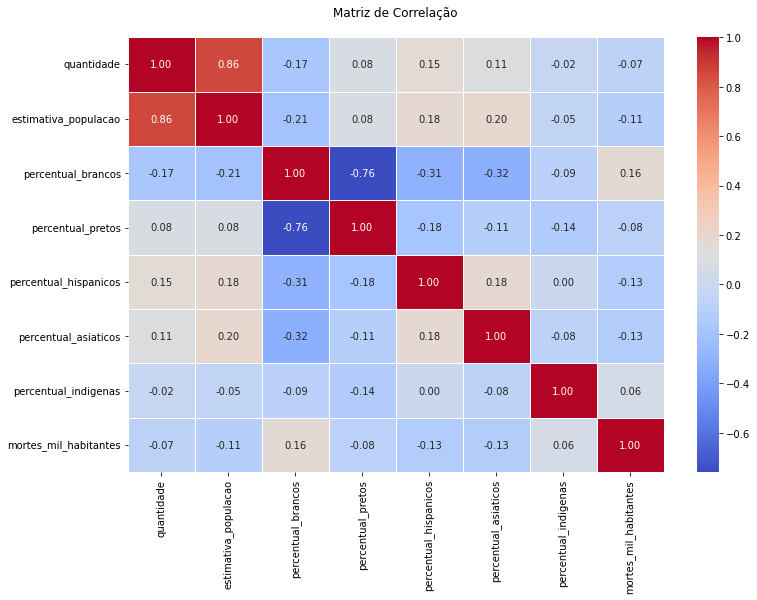

In [0]:
fato_homicidios_mil_habitantes = spark.table("gold.fato_homicidios_mil_habitantes").toPandas()

correlacao = fato_homicidios_mil_habitantes.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlação\n")

plt.show()

### **5 - Análise dos resultados**

Com o auxílio do gráfico gerado no item 4.1, é possível verificar uma concentração dos homicídios no terceiro quartil da variável "renda mediana domiciliar". No entanto, o ponto que mais chama a atenção no gráfico é o fato de que a menor quantidade foi observada para o último quartil, o que é um indício de que os oficiais cometem menos homicídios em áreas de alta renda.

O indício apontado acima é reforçado pelo gráfico do item 4.2, que apresenta forte concentração de homicídios na metade mais pobre das cidades. Ademais, tendo em vista o comportamento desses gráficos, é esperado que áreas de menor escolaridade estariam mais expostas a serem vítimas, dado que a renda média tende a ser menor em áreas de menor escolaridade. O gráfico do item 4.3 suporta essa hipótese e é complementada pela correlação linear negativa exposta no item 4.6.

Ainda no item 4.6, chamaram a atenção as seguintes correlações:

- Variáveis **"percentual_hispanicos"** e **"percentual_em"**: Com uma correlação linear de -0.64, interpretamos que há evidências para indicar que, quanto maior o percentual de hispânicos, menor o percentual de pessoas acima de 25 anos que completaram o ensino médio. Essa medida pode expor um dado demográfico interessante dos Estados Unidos referente à escolaridade por etnia;

- Variáveis **"indice_pobreza"** e **"percentual_em"**: Apresenta correlação linear de -0.53, comportamento esperado conforme texto acima;

- Variáveis **"indice_pobreza"** e **"renda_mediana"**: Pelas mesmas razões apresentadas no item acima, o valor de correlação linear de -0.77 não surpreende;

- Variáveis **"percentual_asiaticos"** e **"renda_mediana"**: Assim como o primeiro item, a correlação linear de 0.51 chama a atenção para um possível dado demográfico interessante dos Estados Unidos, referente à sua população de asiáticos.

De modo que, no item 4.7, é possível verificar o plot dos pontos das variáveis indicadas acima. Embora os gráficos reforcem os valores de correlação indicados acima, cabe pontuar que, à exceção da correlação entre as variáveis "indice_pobreza" e "percentual_em", a análise visual dos gráficos indica que, embora aderentes às conclusões postas acima, a relação entre os dados não parece ser linear, o que deveria ser levado em consideração em eventual modelagem.

Já no item 4.8, verificamos as correlações da tabela "gold.fato_homicidios_mil_habitantes". Não identificamos correlação significativa entre a quantidade de óbitos e o percentual por raça das cidades, o que parece ser corroborado pela tabela apresentada no item 4.5, que apresenta uma medida relativa de óbitos por raça. No entanto, os gráficos apresentados no item 4.4 chamam a atenção.

Nesse item, foram plotadas as distribuições da quantidade de óbitos de acordo com o percentual de cada etnia nas cidades. Os gráficos apresentados à esquerda representam a distribuição absoluta, enquanto os gráficos apresentados à direita indicam a mesma distribuição conforme óbitos por mil habitantes. A ideia da inclusão de uma medida relativa é oriunda do fato de que a análise somente dos valores absolutos pode "desviar" o comportamento do gráfico em razão da diferença populacional entre as cidades. Em outras palavras, entendemos como arriscado considerar que os óbitos que ocorreram em uma cidade com, por exemplo, 70% de brancos seriam comparáveis à distribuição das pessoas identificadas como brancas na população.

Sendo assim, comparando os gráficos apresentados à direita com a distribuição dos percentuais na população americana (item 2.5.2 deste trabalho), incluímos os seguintes comentários:

- Variável **"percentual_brancos"**: É possível verificar visualmente que a distribuição de óbitos por mil habitantes em relação ao percentual de pessoas brancas parece ser bem diferente da distribuição na população desses percentuais. Ao contrário do que acontece na população, os dados parecem estar bem menos concentrados ao redor de 100%, indicando uma incidência mais alta de óbitos para percentuais mais baixos. Entendemos esse ponto como um indício de que os policiais estariam mais propensos à violência em áreas com menos pessoas brancas;

- Variável **"percentual_pretos"**: De forma quase que inversa ao que acontece para a população de pessoas identificadas como brancas, em comparação com a distribuição na população, os dados são bem menos concentrados nas proximidades do zero, o que entendemos como evidência de que os policiais estariam mais propensos a cometer esse tipo de crime em áreas de maior incidência de população preta. Ademais, chama a atenção a quantidade de incidências em cidades cuja população é de maioria preta, tendo em vista a baixíssima incidência desse tipo de cidade na população;

- Variável **"percentual_hispanicos"**: Apresenta comportamento semelhante à variável "percentual_pretos", mas visualmente a diferença parece ser um pouco menor, sendo os dados mais próximos da distribuição na população;

- Variáveis **"percentual_indigenas"** e **"percentual_asiaticos"**: Assim como no caso das pessoas pretas, também há diferença significativa em relação à população. No entanto, com base na tabela do item 4.5, há um baixo volume no valor absoluto informado, o que dificulta a interpretação dessas distribuições.

No arquivo **README**, foram colocadas as seguintes perguntas a serem respondidas ao longo do projeto:

1. Há suporte nos dados para evidenciar que policiais são mais propensos a cometer homicídios sobre pessoas não brancas nos Estados Unidos?

2. Quais são as condições dos homicídios ocorridos nos Estados Unidos? Há uma concentração específica das ocorrências?

3. Há outras métricas que podem influenciar a ação dos policiais além do componente racial nos Estados Unidos?

De modo que entendemos que as perguntas podem ser respondidas da seguinte forma:

1. Há alguma evidência nos dados, mas ela não parece ser definitiva. Embora os pontos apresentados acima quanto às distribuições de dados sejam relevantes, não foi possível verificar em outras métricas algum viés racial claro nos óbitos;

2. Conforme pontuado acima, é possível verificar que parece haver indícios de uma concentração dos óbitos em áreas menos abastadas dos Estados Unidos;

3. Embora não seja possível afirmar de forma definitiva o viés racial, conforme descrito na resposta 1, os indícios e correlações apontam para uma relação causal entre óbitos e áreas mais pobres dos Estados Unidos.